---
**SCRIPT FOR TRAINING M4 MODEL**

---

**David Norman Díaz Estrada**

davidnd@stud.ntnu.no


This scripts contains the procedure followed for training M4 model for image colorization. For the general training strategy and model architecture I took inspiration from [1]. Model M4 uses **VGG16** as the feature extractor (encoder) and was trained on **8000 images** (10% used for validation) from Places365 dataset [2]. This script was run using Google Colab Pro, since normal Colab did not allow training with more than 2000 images.


**References:**

[1] Bhattiprolu, S. “python for microscopists”. (2020).
https://github.com/bnsreenu/python_for_microscopists/blob/master/092-autoencoder_colorize_transfer_learning_VGG16_V0.1.py

[2] Bolei Zhou, Agata Lapedriza, Aditya Khosla, Aude Oliva,
and Antonio Torralba. Places: A 10 million image database
for scene recognition. IEEE Transactions on Pattern Analysis
and Machine Intelligence, 40(6):1452–1464, 2018.

In [ ]:
#Check current GPU:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 15 01:35:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Check available RAM:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive




---
**Load VGG 16**

---





In [ ]:
#Image colorization using Autoencoders. Transfer learning using VGG.


from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

"""
Because we are going to replace the encoder part with VGG16, 
we don’t need it as a classifier, we need it as a feature extractor so, 
the last dense layers isn’t needed we have to pop them up.
here, we iterate on each layer except the last dense layers so, 
we add 19 layer to our model. the dimension of last layer volume is “7x7x512”. 
we will be using that latent space volume as a feature vector to be input to the decoder.
 and the decoder is going to learn the mapping from the latent space vector to ab channels. 
 we want the layers of VGG16 with its original weights without changing them, 
 so that we set the trainable parameter in each layer to false because we don’t want to train them again.
"""
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 

553476096/553467096 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                       

---
Load and pre-process the dataset:

---

In [ ]:
#Load training set:
!unzip '/content/gdrive/My Drive/places365_11k/train.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/Places365_val_00005129.jpg  
  inflating: train/Places365_val_00005130.jpg  
  inflating: train/Places365_val_00005131.jpg  
  inflating: train/Places365_val_00005132.jpg  
  inflating: train/Places365_val_00005133.jpg  
  inflating: train/Places365_val_00005134.jpg  
  inflating: train/Places365_val_00005135.jpg  
  inflating: train/Places365_val_00005136.jpg  
  inflating: train/Places365_val_00005137.jpg  
  inflating: train/Places365_val_00005138.jpg  
  inflating: train/Places365_val_00005139.jpg  
  inflating: train/Places365_val_00005140.jpg  
  inflating: train/Places365_val_00005141.jpg  
  inflating: train/Places365_val_00005142.jpg  
  inflating: train/Places365_val_00005143.jpg  
  inflating: train/Places365_val_00005144.jpg  
  inflating: train/Places365_val_00005145.jpg  
  inflating: train/Places365_val_00005146.jpg  
  inflating: train/Places365_val_00005147.jpg  
  inflating: train/Places365_val_0000

In [ ]:
#Load testing set:
!unzip '/content/gdrive/My Drive/places365_11k/test.zip'

Archive:  /content/gdrive/My Drive/places365_11k/test.zip
   creating: test/
  inflating: test/Places365_val_00010248.jpg  
  inflating: test/Places365_val_00010249.jpg  
  inflating: test/Places365_val_00010250.jpg  
  inflating: test/Places365_val_00010251.jpg  
  inflating: test/Places365_val_00010252.jpg  
  inflating: test/Places365_val_00010253.jpg  
  inflating: test/Places365_val_00010254.jpg  
  inflating: test/Places365_val_00010255.jpg  
  inflating: test/Places365_val_00010256.jpg  
  inflating: test/Places365_val_00010257.jpg  
  inflating: test/Places365_val_00010258.jpg  
  inflating: test/Places365_val_00010259.jpg  
  inflating: test/Places365_val_00010260.jpg  
  inflating: test/Places365_val_00010261.jpg  
  inflating: test/Places365_val_00010262.jpg  
  inflating: test/Places365_val_00010263.jpg  
  inflating: test/Places365_val_00010264.jpg  
  inflating: test/Places365_val_00010265.jpg  
  inflating: test/Places365_val_00010266.jpg  
  inflating: test/Places365_va

Data loader:

In [ ]:
#path = 'images/colorization/'
#path= '/content/gdrive/MyDrive/places365_11k'
path =  '/content/'

#Normalize images - divide by 255
datagenerator = ImageDataGenerator(rescale=1. / 255)


#Resize images, if needed
train_generator = datagenerator.flow_from_directory(path,
                                          batch_size=8000,
                                          target_size=(224, 224),  #resizes the images to ensure dimensions are 224x224 (VGG16 requires this input size)
                                          class_mode=None,
                                          classes=["train"],
                                          shuffle='true',   #change the original order of the images for a better distribution of the training examples
                                          color_mode='rgb'
                                          )

test_generator = datagenerator.flow_from_directory(path,
                                          batch_size=1000,
                                          target_size=(224, 224),   #resizes the images to ensure dimensions are 224x224
                                          class_mode=None,
                                          classes=["test"],
                                          color_mode='rgb'
                                          )

Found 10000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


Pre-Process Training Images:

In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X_train =[]
Y_train =[]
counter=1
for img in train_generator[0]:
  print("Image #: ",counter)
  counter+=1
  try:
      lab = rgb2lab(img)
      X_train.append(lab[:,:,0]) 
      Y_train.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(X_train.shape+(1,)) #dimensions to be the same for X and Y
print(X_train.shape)
print(Y_train.shape)

Streaming output truncated to the last 5000 lines.
Image #:  3003
Image #:  3004
Image #:  3005
Image #:  3006
Image #:  3007
Image #:  3008
Image #:  3009
Image #:  3010
Image #:  3011
Image #:  3012
Image #:  3013
Image #:  3014
Image #:  3015
Image #:  3016
Image #:  3017
Image #:  3018
Image #:  3019
Image #:  3020
Image #:  3021
Image #:  3022
Image #:  3023
Image #:  3024
Image #:  3025
Image #:  3026
Image #:  3027
Image #:  3028
Image #:  3029
Image #:  3030
Image #:  3031
Image #:  3032
Image #:  3033
Image #:  3034
Image #:  3035
Image #:  3036
Image #:  3037
Image #:  3038
Image #:  3039
Image #:  3040
Image #:  3041
Image #:  3042
Image #:  3043
Image #:  3044
Image #:  3045
Image #:  3046
Image #:  3047
Image #:  3048
Image #:  3049
Image #:  3050
Image #:  3051
Image #:  3052
Image #:  3053
Image #:  3054
Image #:  3055
Image #:  3056
Image #:  3057
Image #:  3058
Image #:  3059
Image #:  3060
Image #:  3061
Image #:  3062
Image #:  3063
Image #:  3064
Image #:  3065
Imag

In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures_train = []
for i, sample in enumerate(X_train):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures_train.append(prediction)
vggfeatures_train = np.array(vggfeatures_train)
print(vggfeatures_train.shape) # for each of the 513 input images it has a set of feature maps of size 7x7x512

(8000, 7, 7, 512)


Pre-Process Testing Images:

In [ ]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X_test =[]
Y_test =[]
counter=1
for img in test_generator[0]:
  print("Image #: ",counter)
  counter+=1
  try:
      lab = rgb2lab(img)
      X_test.append(lab[:,:,0]) 
      Y_test.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(X_test.shape+(1,)) #dimensions to be the same for X and Y
print(X_test.shape)
print(Y_test.shape)

In [ ]:
#now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, 
#so we repeated the L channel two times to get 3 dimensions of the same L channel

vggfeatures_test = []
counter=1
for i, sample in enumerate(X_test):
  print("Image #: ",counter)
  counter+=1
  
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures_test.append(prediction)
vggfeatures_test = np.array(vggfeatures_test)
print(vggfeatures_test.shape) # for each of the 513 input images it has a set of feature maps of size 7x7x512

Define Function to plot accuracy and loss of Network during training:


In [ ]:
def plotHistoryNetwork(History):
  from matplotlib import pyplot as plt
  
  #Plot train and test accuracy curves:
  plt.plot(History.history['accuracy'])
  plt.plot(History.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  #Plot train and test loss curves:
  plt.figure()
  plt.plot(History.history['loss'])
  plt.plot(History.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
plotHistoryNetwork(results)

---
**Model M4:**

---

Declare the Decoder architecture:

In [ ]:
#Decoder:
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_5 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_6 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
results = model.fit(x=vggfeatures_train,y=Y_train, validation_split=0.1, batch_size=16, epochs=1000)

Epoch 1/1000
450/450 [==============================] - 7s 11ms/step - loss: 0.0350 - accuracy: 0.6129 - val_loss: 0.0122 - val_accuracy: 0.6479
Epoch 2/1000
450/450 [==============================] - 4s 10ms/step - loss: 0.0113 - accuracy: 0.6599 - val_loss: 0.0106 - val_accuracy: 0.6656
Epoch 3/1000
450/450 [==============================] - 4s 10ms/step - loss: 0.0105 - accuracy: 0.6660 - val_loss: 0.0103 - val_accuracy: 0.6654
Epoch 4/1000
450/450 [==============================] - 4s 10ms/step - loss: 0.0101 - accuracy: 0.6689 - val_loss: 0.0103 - val_accuracy: 0.6617
Epoch 5/1000
450/450 [==============================] - 4s 10ms/step - loss: 0.0098 - accuracy: 0.6730 - val_loss: 0.0104 - val_accuracy: 0.6620
Epoch 6/1000
450/450 [==============================] - 4s 10ms/step - loss: 0.0095 - accuracy: 0.6757 - val_loss: 0.0103 - val_accuracy: 0.6565
Epoch 7/1000
450/450 [==============================] - 4s 10ms/step - loss: 0.0091 - accuracy: 0.6792 - val_loss: 0.0105 - val_ac

In [ ]:
model.save('colorizer_train81-37_val63-58__1000epochs_batch16_8000imgs.h5') # saving the model weights for future use

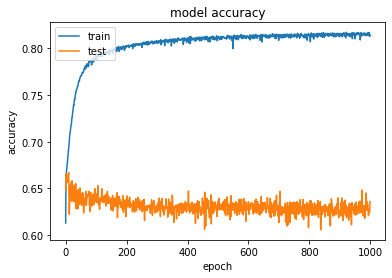

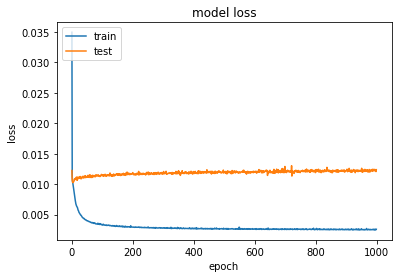

In [ ]:
plotHistoryNetwork(results)

---
Prediction and visualization:

---

In [ ]:
# Predict and image fromt the training set:

from matplotlib import pyplot as plt

batch=0 #only one batch , then set =0
n=6 #Set image to predict,  4,5,6
img1_color=[]
img1= train_generator[batch][n]
plt.imshow(img1)
plt.show()
print(img1.shape)
#print(img1)



#img1 is from the training set, so it is already scaled to 224x224 and scalen in RGB range [0,1]

lab = rgb2lab(img1)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
#print(L.shape)
vggpred = newmodel.predict(L) #get features
ab = model.predict(vggpred)
#print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

plt.imshow(lab2rgb(cur))
plt.show()
#imsave('images/colorization2/vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))

In [ ]:
# Predict and image fromt the testing set:

from matplotlib import pyplot as plt

batch=0 #only one batch , then set =0
n=15 #Set image to predict,  7, 8,9, 11,13,15
img1_color=[]
img1= test_generator[batch][n]
plt.imshow(img1)
plt.show()
print(img1.shape)
#print(img1)



#img1 is from the training set, so it is already scaled to 224x224 and scalen in RGB range [0,1]

lab = rgb2lab(img1)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
#print(L.shape)
vggpred = newmodel.predict(L) #get features
ab = model.predict(vggpred)
#print(ab.shape)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

plt.imshow(lab2rgb(cur))
plt.show()
#imsave('images/colorization2/vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))